#### Importação de bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Carregar os resultados

In [2]:
cv_total = pd.read_csv("results/resultados_cv_total.csv")
cv_total_features = pd.read_csv("results/resultados_cv_total_features.csv")
tt = pd.read_csv("results/resultados_TT.csv")
tt_features = pd.read_csv("results/resultados_TT_features.csv")

# Renomear colunas para consistência
tt = tt.rename(columns={'Acurácia': 'Acurácia Média', 'Sensibilidade': 'Sensibilidade Média',
                        'Especificidade': 'Especificidade Média', 'AUC': 'AUC Médio'})
tt_features = tt_features.rename(columns={'Acurácia': 'Acurácia Média', 'Sensibilidade': 'Sensibilidade Média',
                                          'Especificidade': 'Especificidade Média', 'AUC': 'AUC Médio'})

#### Função para plotar métricas

In [3]:
def plot_metric(df1, df2, metric, title):
    modelos = df1['Modelo']
    x = np.arange(len(modelos))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # É necessário salvar o objeto das barras em variáveis (rects1, rects2)
    rects1 = ax.bar(x - width/2, df1[metric], width, label='Todas as features')
    rects2 = ax.bar(x + width/2, df2[metric], width, label='Selecionadas')

    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(modelos)
    ax.legend()
    
    # Aumentamos um pouco o limite superior para o texto não ficar cortado
    plt.ylim(0, 1.15) 

    # Adiciona as etiquetas de porcentagem
    # fmt='{:.1%}' converte 0.5 para 50.0%
    # padding=3 dá um pequeno espaço entre a barra e o texto
    ax.bar_label(rects1, fmt='{:.1%}', padding=3)
    ax.bar_label(rects2, fmt='{:.1%}', padding=3)

    plt.show()

#### Experimento A: Validação Cruzada 10-Fold

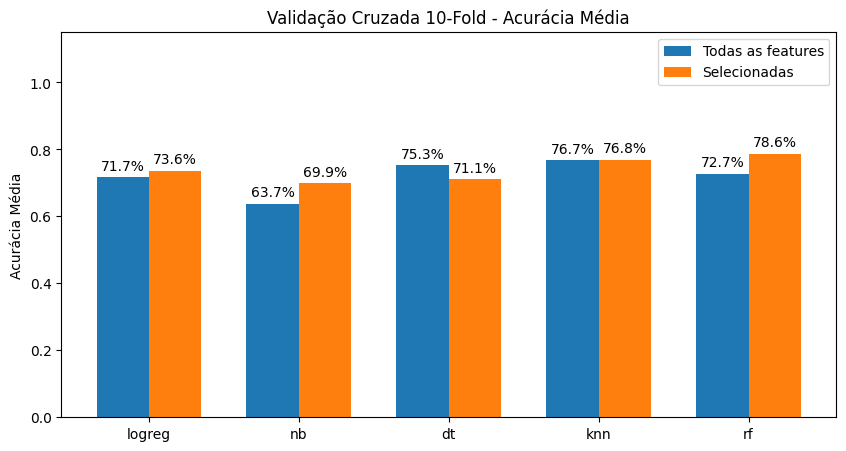

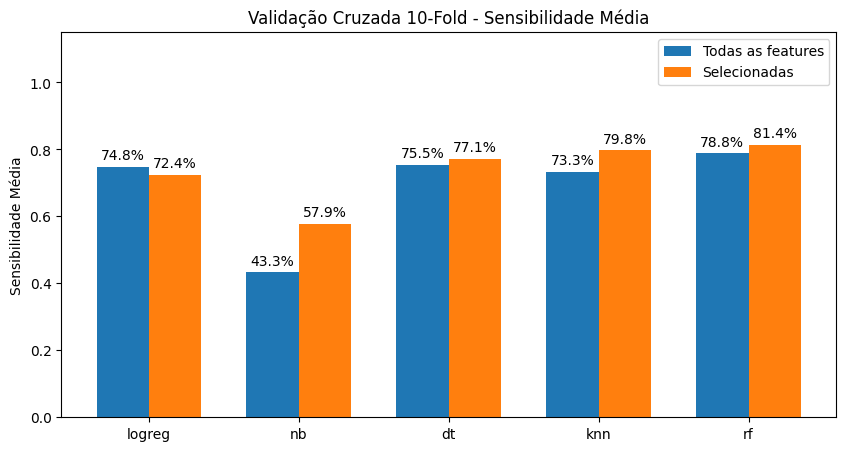

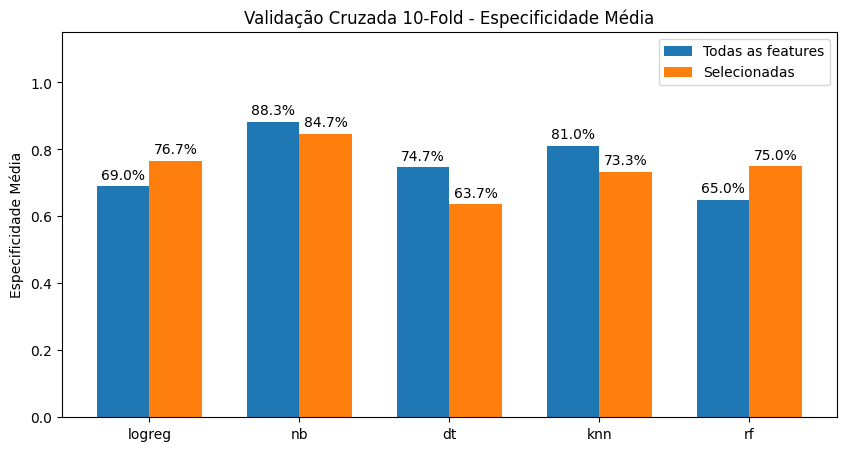

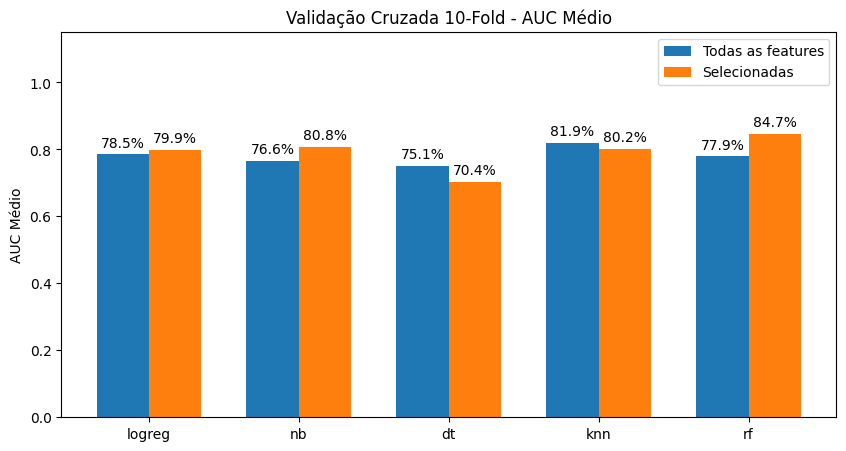

In [4]:
plot_metric(cv_total, cv_total_features, 'Acurácia Média', 'Validação Cruzada 10-Fold - Acurácia Média')
plot_metric(cv_total, cv_total_features, 'Sensibilidade Média', 'Validação Cruzada 10-Fold - Sensibilidade Média')
plot_metric(cv_total, cv_total_features, 'Especificidade Média', 'Validação Cruzada 10-Fold - Especificidade Média')
plot_metric(cv_total, cv_total_features, 'AUC Médio', 'Validação Cruzada 10-Fold - AUC Médio')

Experimento A (CV 10-fold)
- A seleção de features melhorou Acurácia média em quase todos os modelos, especialmente para rf e nb;
- knn e rf apresentam melhor desempenho geral, com alto AUC (>0.8) mesmo sem seleção de features;
- nb tem sensibilidade baixa, mas alta especificidade, ou seja, acerta mais os negativos do que os positivos

#### Experimento B: Treino/Teste 80/20

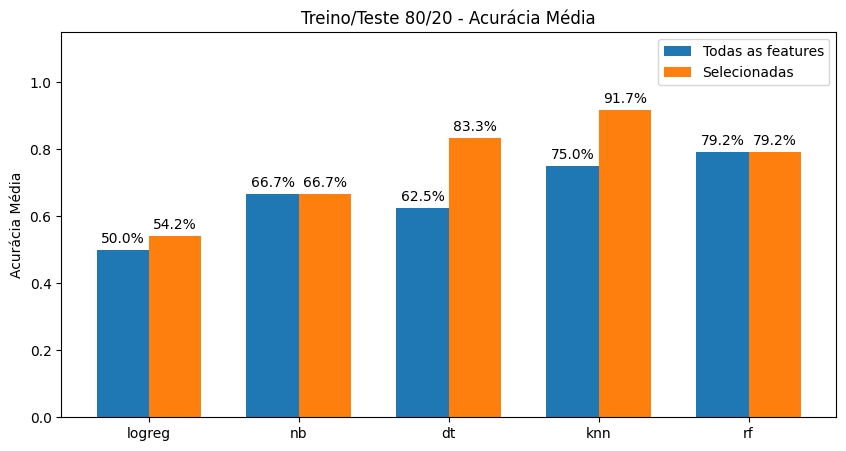

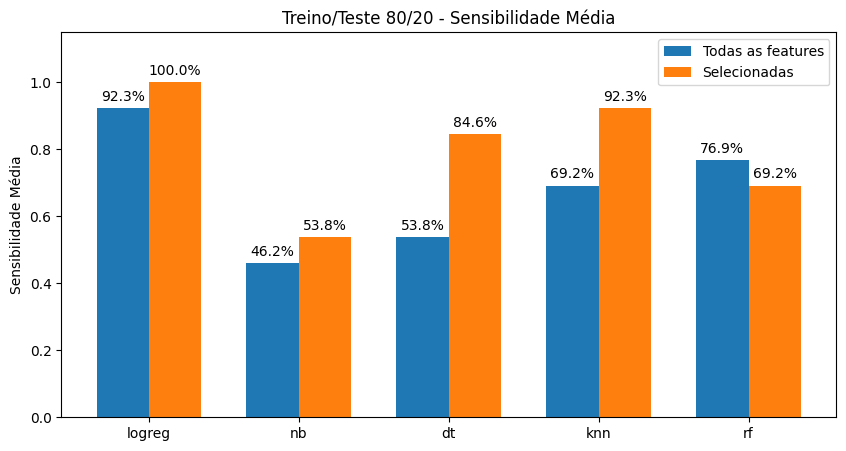

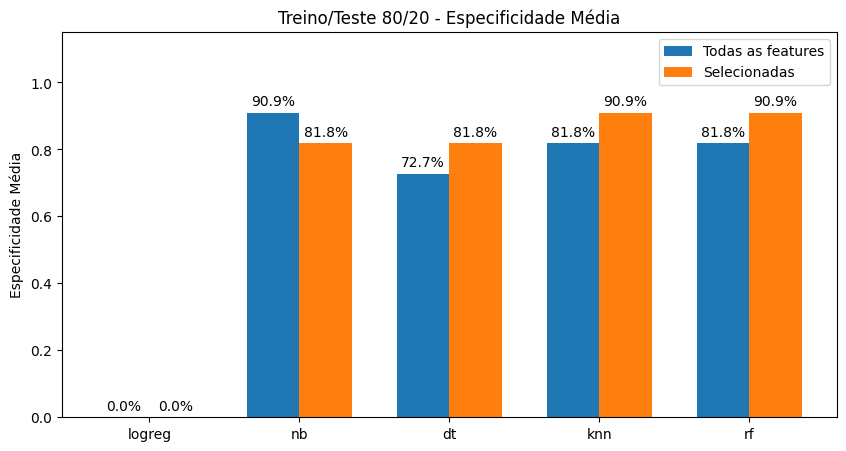

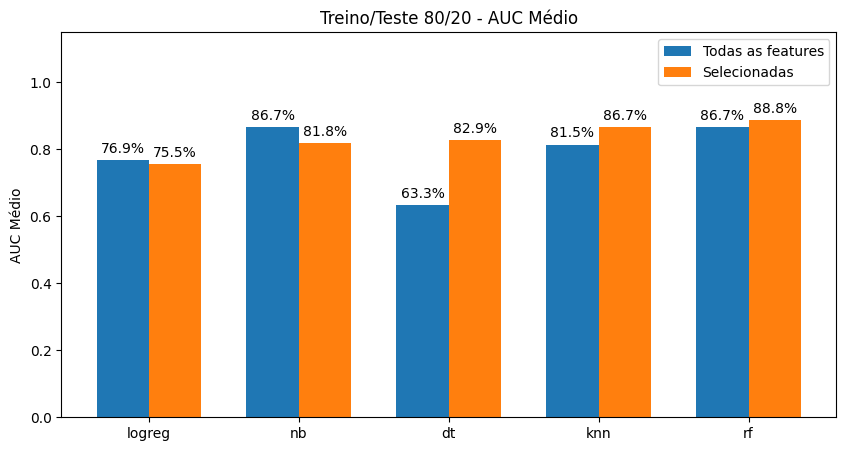

In [5]:
plot_metric(tt, tt_features, 'Acurácia Média', 'Treino/Teste 80/20 - Acurácia Média')
plot_metric(tt, tt_features, 'Sensibilidade Média', 'Treino/Teste 80/20 - Sensibilidade Média')
plot_metric(tt, tt_features, 'Especificidade Média', 'Treino/Teste 80/20 - Especificidade Média')
plot_metric(tt, tt_features, 'AUC Médio', 'Treino/Teste 80/20 - AUC Médio')


Experimento B (Train/Test 80/20)
- O desempenho varia mais por conta do conjunto de teste ser pequeno; 
- A seleção de features trouxe grandes ganhos para knn (Acurácia 0.916, Sensibilidade 0.923, Especificidade 0.909) e dt;
- logreg ainda sofre com sensibilidade/especificidade muito desbalanceadas quando se usa apenas as features selecionadas;
- rf mantém bom desempenho com ou sem seleção de features, mas melhora no AUC ao usar apenas as features selecionadas

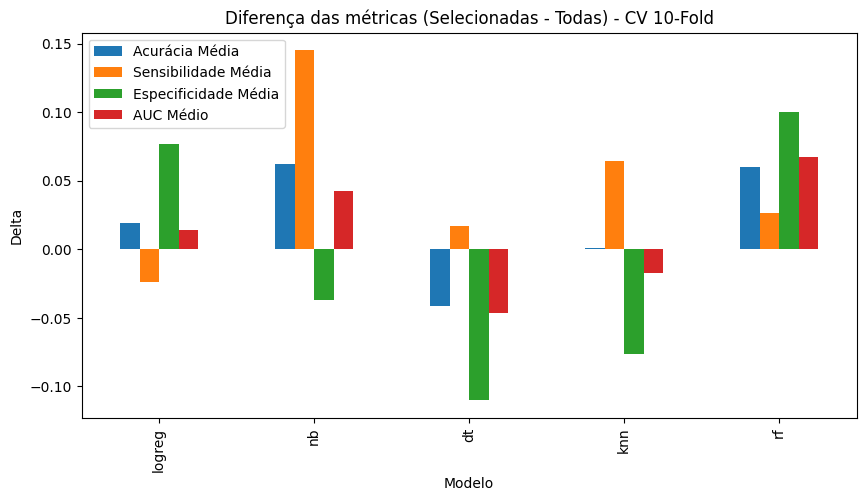

In [6]:
delta = cv_total_features.set_index('Modelo') - cv_total.set_index('Modelo')
delta = delta[['Acurácia Média', 'Sensibilidade Média', 'Especificidade Média', 'AUC Médio']]
delta.plot(kind='bar', figsize=(10,5))
plt.title('Diferença das métricas (Selecionadas - Todas) - CV 10-Fold')
plt.ylabel('Delta')
plt.show()

Random Forest (rf)
- Esse foi o único modelo que melhorou em todas as métricas (Acurácia, Sensibilidade, Especificidade e AUC) após a seleção de atributos;
- A barra verde (Especificidade) cresceu consideravelmente. Isso sugere que, para o Random Forest, as variáveis descartadas eram de fato ruído e a limpeza dos dados tornou o modelo muito mais robusto e preciso

(Trade-off): nb e logreg
- O Naive Bayes (nb): Teve um ganho gigantesco em Sensibilidade (barra laranja), ficou ótimo em detectar a classe positiva. Porém, decaiu na Especificidade (barra verde negativa), o que significa que ele começou a gerar mais falsos positivos;

- Regressão Logística (logreg): O oposto do Naive Bayes. A seleção de atributos fez a Especificidade (barra verde) subir muito, tornando o modelo mais "criterioso", mas a Sensibilidade (barra laranja) caiu representando a dificuldade em detectar a classe positiva

Decision Tree (dt)
- A Árvore de Decisão sofreu com a seleção de atributos. Quase todas as métricas caíram, especialmente a Especificidade e a AUC
- Isso indica que a Árvore de Decisão dependia das variáveis que foram removidas para fazer boas divisões nos nós, ou que a seleção causou algum tipo de instabilidade no modelo

KNN (knn)

- Teve um desempenho misto, tendendo ao negativo. Embora a Sensibilidade tenha subido, a Especificidade caiu drasticamente (barra verde grande para baixo). A Acurácia praticamente não mudou (barra azul quase invisível).

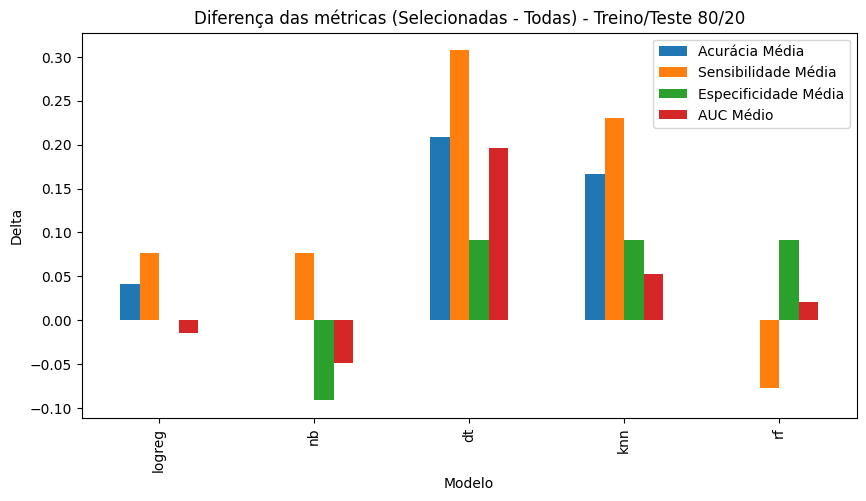

In [7]:
# Selecionar apenas as colunas numéricas
numerical_cols = ['Acurácia Média', 'Sensibilidade Média', 'Especificidade Média', 'AUC Médio']

# Garantir que os valores são float
tt_num = tt[numerical_cols].astype(float)
tt_features_num = tt_features[numerical_cols].astype(float)

# Usar 'Modelo' como índice
tt_num.index = tt['Modelo']
tt_features_num.index = tt_features['Modelo']

# Calcular delta
delta = tt_features_num - tt_num

# Plotar
delta.plot(kind='bar', figsize=(10,5))
plt.title('Diferença das métricas (Selecionadas - Todas) - Treino/Teste 80/20')
plt.ylabel('Delta')
plt.show()


Decision Tree (dt): Foi o modelo que mais se beneficiou da limpeza de dados
- Todas as métricas melhoraram. Houve um ganho massivo na Sensibilidade (barra laranja), subindo mais de 30%;
- O modelo original (dt com todas as features) provavelmente estava sofrendo muito com ruído (overfitting em variáveis irrelevantes). Ao remover o "lixo", a árvore conseguiu generalizar muito melhor

O KNN também teve melhoras significativas em todas as métricas mostradas
- O algoritmo KNN depende do cálculo de distância entre pontos. Quando há muitas features irrelevantes, a distância fica distorcida. Ao reduzir as features, os vizinhos corretos foram aproximados, melhorando a classificação

O Random Forest (rf) sofreu um trade-off
- A Especificidade (barra verde) melhorou, mas a Sensibilidade (barra laranja) piorou significativamente;
- A seleção de features tornou o Random Forest mais conservador ou mudou o viés dele. Ele ficou melhor em dizer o que não é a classe alvo, mas pior em detectar quando é. O ganho geral (AUC - barra vermelha) foi pequeno.

O Naive Bayes (nb) e Regressão Logística (logreg)
- nb: Sofreu com a seleção de features. Embora a sensibilidade tenha subido, ele perdeu muita Especificidade e AUC. Isso indica que a seleção pode ter removido features que eram importantes para o Naive Bayes distinguir os "negativos";
- logreg: Teve um ganho moderado em sensibilidade e acurácia, mas uma leve perda em AUC. Foi um impacto menor do que nas árvores

#### Comparação dos dois gráficos

In [8]:
cv_total = pd.read_csv("results/resultados_cv_total.csv")
cv_total_features = pd.read_csv("results/resultados_cv_total_features.csv")
tt = pd.read_csv("results/resultados_TT.csv")
tt_features = pd.read_csv("results/resultados_TT_features.csv")

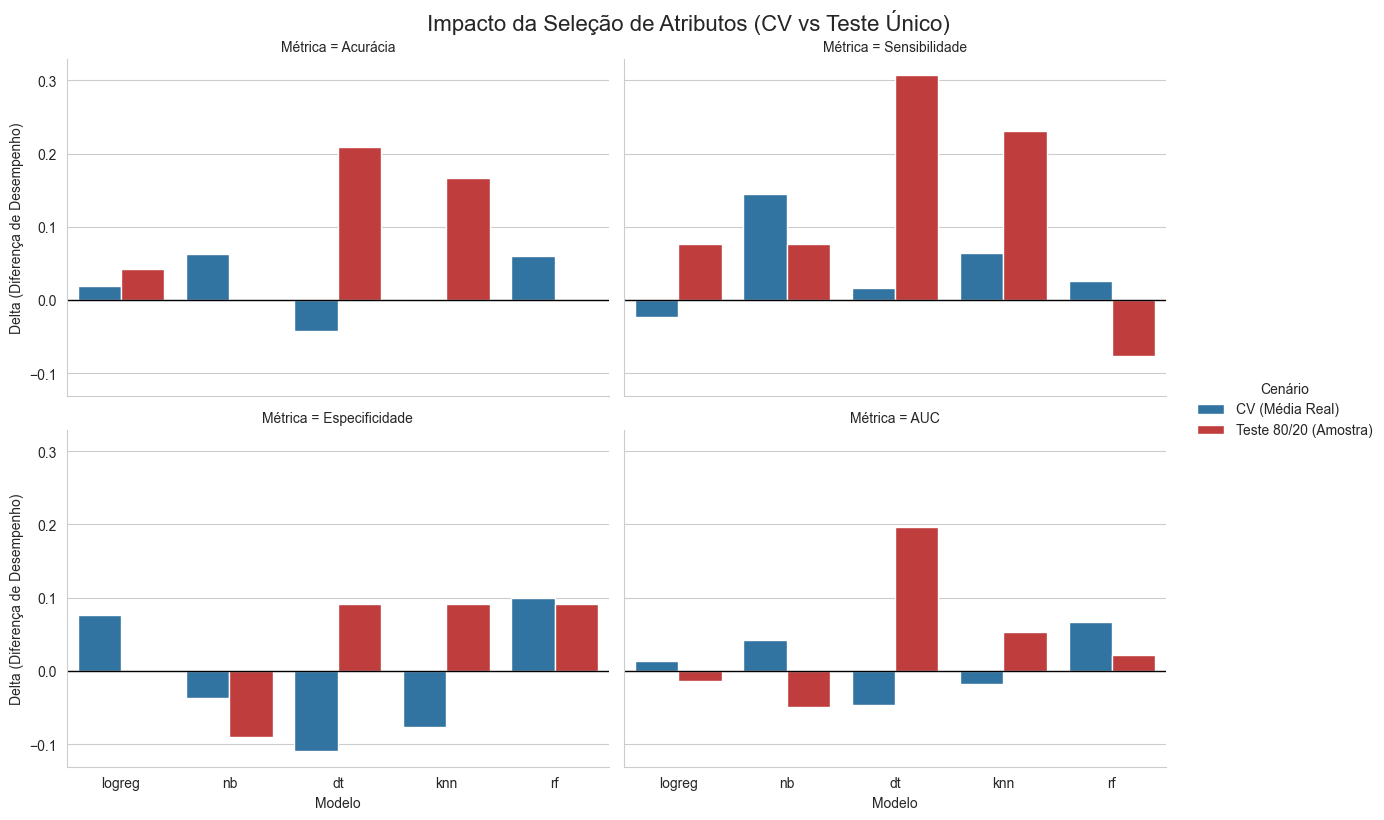

In [12]:
metrics_map = {
    'Acurácia': 'Acurácia',
    'Sensibilidade': 'Sensibilidade',
    'Especificidade': 'Especificidade',
    'AUC': 'AUC'
}

# 3. Calcular os Deltas (Diferenças) e Organizar os Dados
data_list = []
models = cv_total['Modelo'].unique()

for model in models:
    # Seleciona a linha correspondente ao modelo em cada arquivo
    row_cv_all = cv_total[cv_total['Modelo'] == model].iloc[0]
    row_cv_sel = cv_total_features[cv_total_features['Modelo'] == model].iloc[0]
    row_tt_all = tt[tt['Modelo'] == model].iloc[0]
    row_tt_sel = tt_features[tt_features['Modelo'] == model].iloc[0]

    for metric_name, metric_col_base in metrics_map.items():
        metric_cv_col = metric_col_base + " Média"
        if metric_col_base == "AUC": metric_cv_col = "AUC Médio" 

        # Calcular Delta: (Valor com Seleção) - (Valor com Todas)
        delta_cv = row_cv_sel[metric_cv_col] - row_cv_all[metric_cv_col]
        delta_tt = row_tt_sel[metric_col_base] - row_tt_all[metric_col_base]

        data_list.append({
            'Modelo': model,
            'Métrica': metric_name,
            'Cenário': 'CV (Média Real)', 
            'Delta': delta_cv
        })
        data_list.append({
            'Modelo': model,
            'Métrica': metric_name,
            'Cenário': 'Teste 80/20 (Amostra)',
            'Delta': delta_tt
        })

df_plot = pd.DataFrame(data_list)
sns.set_style("whitegrid")

g = sns.catplot(
    data=df_plot,
    x='Modelo', 
    y='Delta', 
    hue='Cenário', 
    col='Métrica', 
    col_wrap=2,    
    kind='bar', 
    height=4, 
    aspect=1.5,
    palette=['#1f77b4', '#d62728']
)

g.map(plt.axhline, y=0, color='black', linewidth=1)

g.fig.suptitle('Impacto da Seleção de Atributos (CV vs Teste Único)', y=1.02, fontsize=16)
g.set_axis_labels("Modelo", "Delta (Diferença de Desempenho)")

plt.show()

- O gráfico mostra que a seleção de atributos tem impacto positivo no desempenho dos modelos, principalmente quando avaliados em um conjunto de teste independente

- No cross-validation, os ganhos são mais modestos, indicando que a validação cruzada já reduz parte do ruído. No entanto, no teste 80/20 observamos ganhos substanciais em acurácia, sensibilidade e AUC, evidenciando que a remoção de atributos irrelevantes melhora a capacidade de generalização dos modelos

#### Conclusão

- Após a comparação dos experimentos, o modelo selecionado como final do estudo foi o Random Forest avaliado no cenário de treino/teste (80/20)

- Esse modelo apresentou o melhor desempenho no conjunto de teste independente, com acurácia de 79%, sensibilidade de 76%, especificidade de 82% e AUC de 0.867, demonstrando excelente capacidade de generalização e equilíbrio entre as métricas

- O Experimento B foi utilizado como referência final por representar uma avaliação mais realista, uma vez que o modelo é testado em dados completamente novos